<a href="https://colab.research.google.com/github/Harvengtj/mddm/blob/main/Copie_de_WQRN_hands_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on Notebook for WQRN3 Tutorial: Quantum Networks from Scratch


This notebook is created by Naphan Benchasattabuse (whit3z), Ryosuke Satoh (cocori), Rodney Van Meter from Keio University.

The notebook is licensed under [Creative Commons Attribution license (CC BY 4.0 license)](https://creativecommons.org/licenses/by/4.0/).



# Getting Set Up

In Jupyter notebook, there are two types of cells, code cell and text cell.

Code cells are places where you can write code and execute it (in this case Python). In order to run the code, you need to start a runtime or a kernel. The runtime normally starts automatically at start up. Any piece of code you write will be run by the runtime and all the variables will be stored even if you erase the code so be aware of that! If you want to clear all the variables and start fresh, you can restart the runtime. Each cell can be executed in any order thus if you run cells not in the order that you intend it might have output errors or unintended behaviours.

Text cells are used to add comments and documentation to the code cells. It can also be used like a description or a note to guide your ideas through the notebook like this cell you're reading.

### Tips on navigating through the notebook

- you can use `shift + enter` to run a code cell or to render the text cell and move the focus on to the next cell
- if you want to instead run a code cell and stay at the same cell, in case you're trying to change or debug the code, us `ctrl + enter`
- any output of the last line inside a code cell will displayed without the need for `print()` command.

### Tips on basic troubleshooting

- if you try to run a code cell and it outputs an error. Check if you are trying to access a variable that should be previously declared in prior cells or not. If so, check if the prior cells are already executed.

### Let's try executing the first code cell below.

You can run a code cell by either clicking the "play" icon by hovering your mouse over the `[ ]` in front of the cell. After it is executed it, a number will be shown inside the brackets which denotes how many code cells have been executed so far. So if this you're starting this from a newly created kernel, it should show `[1]`.

The output of cell below should be `5`.

In [ ]:
## try adding numbers
2 + 3

5

### Run the cell below to install all required libraries for today's tutorial

We are using [Qiskit]() to simulate quantum computing and visualize output statistics.

In [2]:
!pip install qiskit
!pip install qiskit-aer
!pip install 'qiskit[visualization]'
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=b0c93ea64519e12d0764009c15820149b4f533387e6e3e5edc9f3936b4e959e9
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


Template code and some helper functions

In [3]:
# Importing required libraries
import numpy as np

from qiskit_aer import Aer, AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit import user_config
from qiskit.quantum_info import partial_trace
from IPython.display import Javascript

# make the output height tall enough not needing scrolling
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Initialize backends simulators to visualize circuits
sv_sim = Aer.get_backend('statevector_simulator')
qasm_sim = Aer.get_backend('qasm_simulator')

# Setting mpl as default drawer
%env QISKIT_SETTINGS {}
user_config.set_config('circuit_drawer', 'mpl')

<IPython.core.display.Javascript object>

env: QISKIT_SETTINGS={}


In [4]:
# Our helper function (modified by whit3z) to make it work on a standalone notebook
def show_info(qc, use_statevector_only=False):
    """this function accepts a quantum circuit object and print out the counts / statevector"""
    qc_remove_measurement = qc.remove_final_measurements(inplace=False)
    counts = qasm_sim.run(qc, shots=10000).result().get_counts()
    statevector = sv_sim.run(qc_remove_measurement).result().get_statevector()
    print('====== state_vector ======')
    display(statevector.draw(output='latex'))
    print('')
    print('====== true probability distribution =====')
    display(plot_histogram({k: np.abs(v) ** 2 for k, v in statevector.to_dict().items()}, title='true probability distribution', color='midnightblue'))
    print('====== counts from measurements ======')
    display(plot_histogram(counts, title='readout results histogram'))

def show_info_partial(qc, qubit_list, use_statevector_only=False):
    pass

original_draw = None

if original_draw is None:
    original_draw = QuantumCircuit.draw
    def draw(self):
        display(original_draw(self))
    QuantumCircuit.draw = draw

creating custom LaTeX command

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$


# Basic of quantum gates (unitary operations)

---

In quantum computing, the basic operations aren't just the bit-wise operations (e.g., and, or, not, xor, etc) like in the case of classical low-level bit string manipulation.

Since the quantum states are defined as a unit vector in the Hilbert space, like in linear algebra, operations acting on a vector can be defined as a matrix (linear operator). Since we also want the new state vector to be a valid state vector after the operation, the operator (or the matrix) must be unitary to preserve this constraints.



## Defining circuits

In the circuit model of quantum computing, we cannot define a state without first defining a quantum circuit.

in Qiskit, we can define a quantum circuit like in example cell below.

There are two main ways to define a quantum circuit.

1. Using shorthand notation `QuantumCircuit(<#qubit>, <#classical_bit>)` then you refer to the qubit in the circuit using index.
2. First defining registers and initialize the circuit with them.

The second approach with register naming will be useful once we deal with multiple qubits and separating them by their responsibility. We will start using this when we get to Teleportation to see the context clearer.

In [5]:
# Creating a simple 1 qubit circuit

# shorthand version
shorthand_circuit = QuantumCircuit(1, 1) # 1 qubit, 1 classical bit for readout

# by composing from registers
q_reg = QuantumRegister(1, 'qreg')
c_reg = ClassicalRegister(1, 'creg')
qc = QuantumCircuit(q_reg, c_reg)

### Exercise: Try defining you own circuits

Try creating new quantum circuits with above approaches. Try having two or more quantum registers inside a circuit.

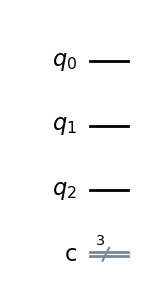

In [17]:
"""Exercise: Try creating circuits here"""
circuit = QuantumCircuit(3, 3) # 2 qubits, 2 classical bits for readout
circuit.draw() # plot the schematic

## Applying quantum gates (operations)

Let's see a few basic single qubit gates.

Identity gate (do nothing)

$I=\left[\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right]$

The three Pauli matrices (the 3 Pauli gates)

$
X=\sigma_{x}=\left[\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right], \\
Y=\sigma_{y}=\left[\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right], \\
Z=\sigma_{z}=\left[\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right] .
$

The Pauli X is the equivalent of classical NOT gate.

The Hadamard gate (H) is commonly used to create superposition

$H=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]$

To create an equal superposition between $\ket{0}$ and $\ket{1}$ via
$ H \ket{0}$ by calling `qc.h(<qubit_index>)`

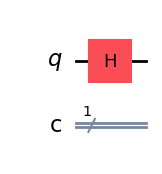

In [18]:
# creating a uniform superposition

qc = QuantumCircuit(1, 1)
qc.h(0)
qc.draw()

The other gates mentioned above can be called in a similar fashion

`QuantumCircuit.x()` `QuantumCircuit.y()` `QuantumCircuit.z()`

There are also some useful gates to define non-uniform superposition such as [RY gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RYGate.html) which is a Pauli-Y operator with adjustable angle

$RY(\theta)=\exp \left(-i \frac{\theta}{2} Y\right)=\left(\begin{array}{cc}\cos \frac{\theta}{2} & -\sin \frac{\theta}{2} \\ \sin \frac{\theta}{2} & \cos \frac{\theta}{2}\end{array}\right)$

There are also [Rx](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXGate.html) and [Rz](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZGate.html) as well.


Note: For other gates defined in Qiskit you can check them out [here](https://qiskit.org/documentation/apidoc/circuit_library.html).

## Drawing the Circuits

To draw a circuit, we can use command `.draw()`.

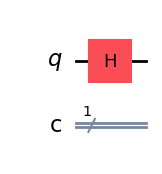

In [19]:
# initialize
qc = QuantumCircuit(1, 1)
qc.h(0)

# draw
qc.draw()

### Exercise: create and draw circuit

Try to create a circuit with 2 qubits. Applying X then Z on first qubit and applying H on second qubit.

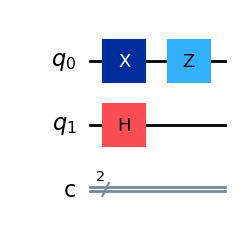

In [20]:
""" Exercise: Fill in your code here """
qc = QuantumCircuit(2,2)
# First qubit
qc.x(0)
qc.z(0)
# Second qubit
qc.h(1)
# Show schematic
qc.draw()

## Getting information out of circuits by measuring qubits

In order to get useful information out of a quantum system or quantum states. We must perform a measurement on the states to extract information. It is worth noting that the information we can extract is **classical**.

measurement can be done in Qiskit by calling `QuantumCircuit.measure(<qubit>, <classical_bit>)`. So far we have define our circuits to have classical bits but never used it, now we get to see why we need classical bits in our circuits.

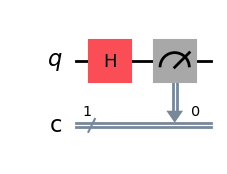

In [21]:
# initialize
qc = QuantumCircuit(1, 1)
qc.h(0)

# adding measurement part
qc.measure(0, 0)
qc.draw()

We provide a helper function which when you pass a circuit with measurement attached at the end, it will output the readout distribution (this helper function will run the circuit with 10,000 shots) and also state vector output right before the final measurement.

We can call it by
`show_info(qc)`

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


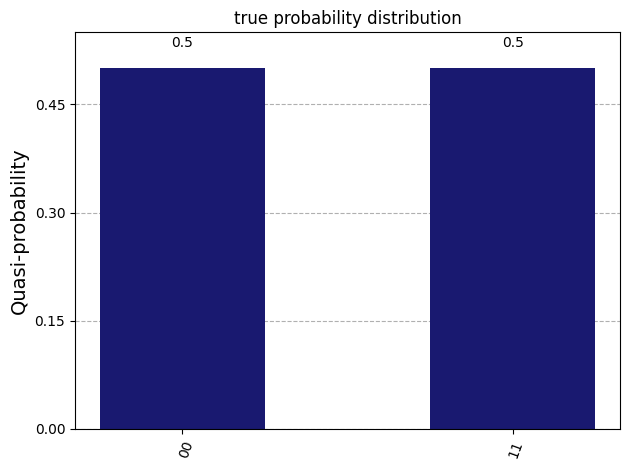

====== counts from measurements ======


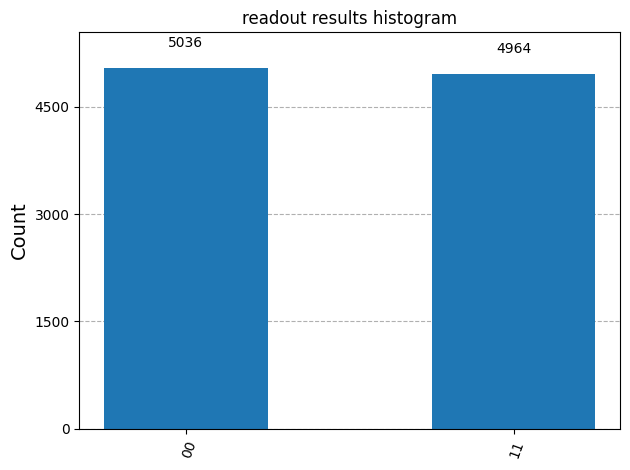

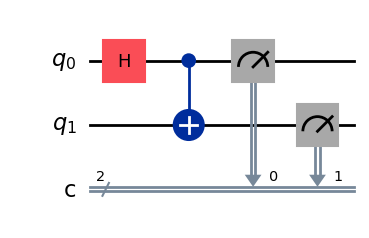

In [22]:
# show_info(qc)

qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1]) # we measure q[0] and q[1] and store the result in creg[0] and creg[1]
show_info(qc)
qc.draw()

### "Endianness" in kets and diagrams

A circuit with multiple qubits can be drawn like the image below:

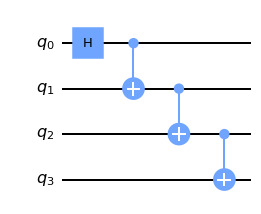

In this case, if we write down the qubits left to right following the top to bottom ordering, the state vector would be written as $\ket{q_0, q_1, q_2, q_3}$ ("Big Endian notation").

But if we follow the computer science way of writing binary strings or binary number by putting higher order bit (most significant bit MSB) on the left, the "Little Endian" notation, we would write our state as $\ket{q_3, q_2, q_1, q_0}$.

Qiskit, by default, draws $q_0$ at the top, and writes it last in the register.

Learn more about the endians on the [wikipedia page](https://en.wikipedia.org/wiki/Endianness)

Learn more about the notation in [Qiskit textbook](https://qiskit.org/textbook/ch-states/representing-qubit-states.html)

# Entanglement and the Bell States

---

Recall from our lesson that the maximally entangled two-qubit states or Bell pair have four different forms where each of them has S value (CHSH inequality) equals to $2\sqrt{2}$.

$\begin{aligned}
\left|\Phi^{+}\right\rangle=\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)
\\
\left|\Phi^{-}\right\rangle=\frac{1}{\sqrt{2}}(|00\rangle-|11\rangle)
\\
\left|\Psi^{+}\right\rangle=\frac{1}{\sqrt{2}}(|01\rangle+|10\rangle)
\\
\left|\Psi^{-}\right\rangle=\frac{1}{\sqrt{2}}(|01\rangle-|10\rangle)
\end{aligned}$

## Creating Bell States

The most common form of Bell pair is the $\Phi^+$ state. We can create it by the code below:

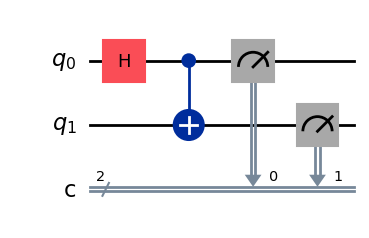

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


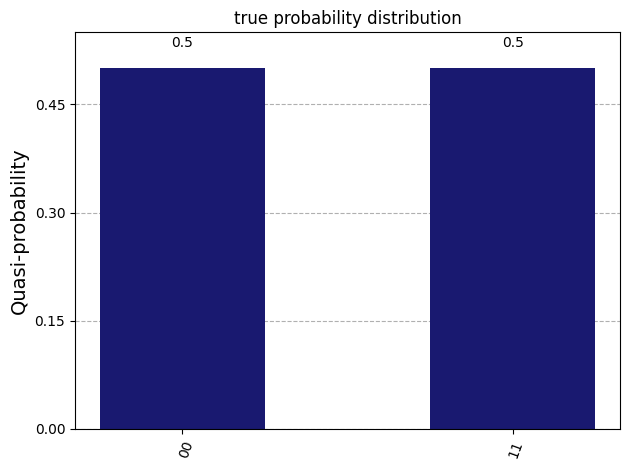

====== counts from measurements ======


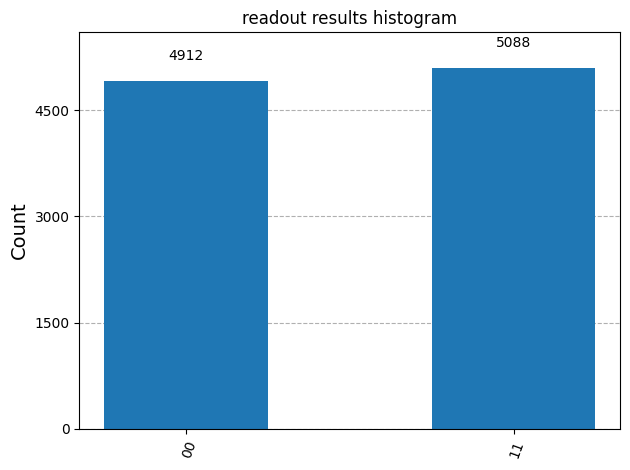

In [23]:
# Creating phi+ circuit

qc = QuantumCircuit(2, 2)
qc.h(0) # q[0] = H|0> = |+>
qc.cx(0, 1) # q[0] = control qubit; q[1] = target qubit
qc.measure([0, 1], [0, 1])

# see the circuit and its output
qc.draw()
show_info(qc)

### Two qubit gate (CNOT Gate)

The circuit above uses a new gate which we haven't talked about, the CNOT gate.

The CNOT or CX gate can be defined in the matrix form as

$\mathrm{CNOT}=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0\end{array}\right]$

if we use the Qiskit notation of qubit ordering.

In the usual textbook (Big Endian) you would see it described as

$\mathrm{CNOT}=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right]$

Without two qubit gates, we cannot create entanglement which is fundamental to the weirdness of quantum mechanics and core to the quantum advantage over classical computing.

### Composing circuits

So far, every time we introduce a new circuit we create a new variable and append gates to our circuits using the basis gates provided by Qiskit.

This is not a good thing when we want to build smaller components and compose them into a bigger/longer circuits.

We can define circuits for use later and compose them using the code below.
Let's see an example circuit that create the $\Phi_+$ state.

phi plus circ


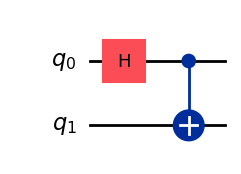

two qubit measurement circ


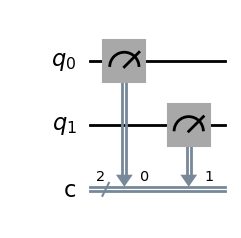

the composed circuit


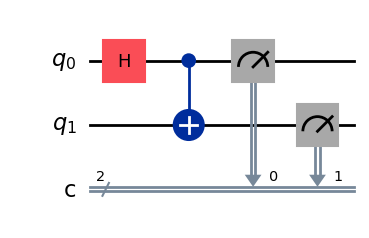

In [24]:
def phi_plus_prep():
    # Circuit for creating Phi+

    phi_plus_circ = QuantumCircuit(2)
    phi_plus_circ.h(0)
    phi_plus_circ.cx(0, 1)
    return phi_plus_circ

def two_qubit_measurement_circuit():
    # Circuit to append 2 qubit measurement
    two_qubit_measurement_circ = QuantumCircuit(2, 2)
    two_qubit_measurement_circ.measure([0, 1], [0, 1])
    return two_qubit_measurement_circ

# See the two circuits separately
print('phi plus circ')
phi_plus_prep().draw()
print('two qubit measurement circ')
two_qubit_measurement_circuit().draw()


# To compose the two components into our circuit
## First define a new circuit

qc = QuantumCircuit(2, 2)
qc = qc.compose(phi_plus_prep())
qc = qc.compose(two_qubit_measurement_circuit())
print('the composed circuit')
qc.draw()

### Exercise: Create $\Phi^-$ State

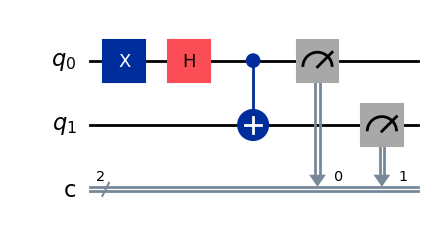

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


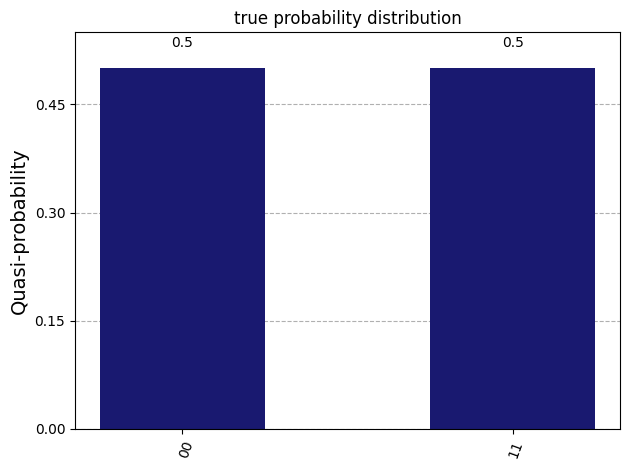

====== counts from measurements ======


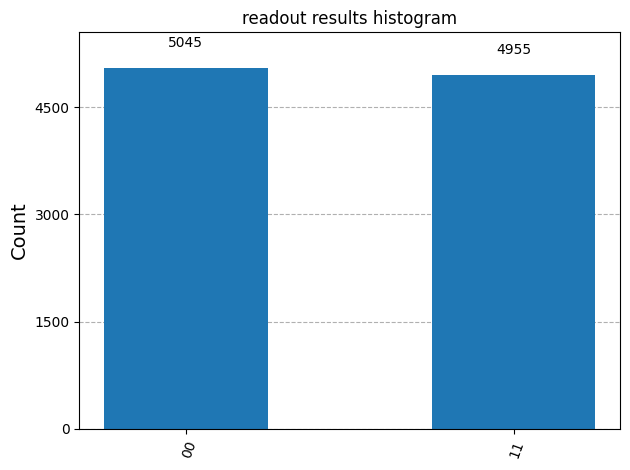

In [26]:
# Creating Phi-

def phi_minus_prep():
    phi_minus_circ = QuantumCircuit(2)

    """Complete the code"""
    # Other method in answer sheet
    phi_minus_circ.x(0)
    phi_minus_circ.h(0)
    phi_minus_circ.cx(0, 1)
    """End"""
    return phi_minus_circ

# to see the measurement result and draw the circuit
qc = QuantumCircuit(2, 2)
qc = qc.compose(phi_minus_prep()).compose(two_qubit_measurement_circuit())
qc.draw()
show_info(qc)

### Exercise: Create $\Psi^+$ State

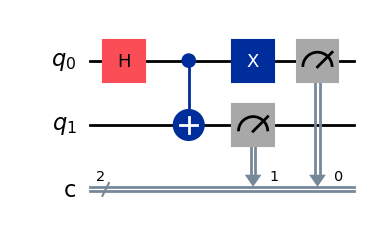

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


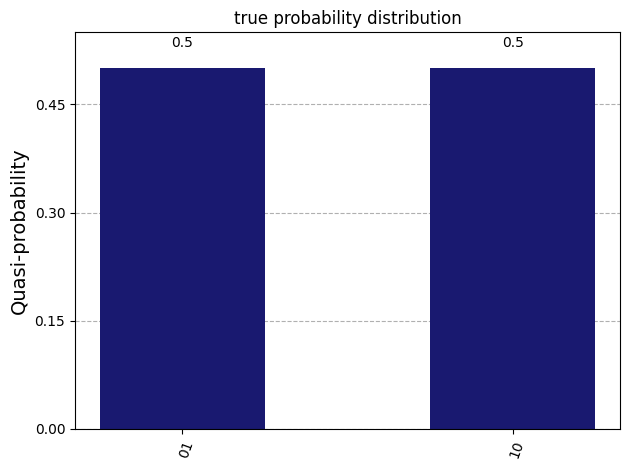

====== counts from measurements ======


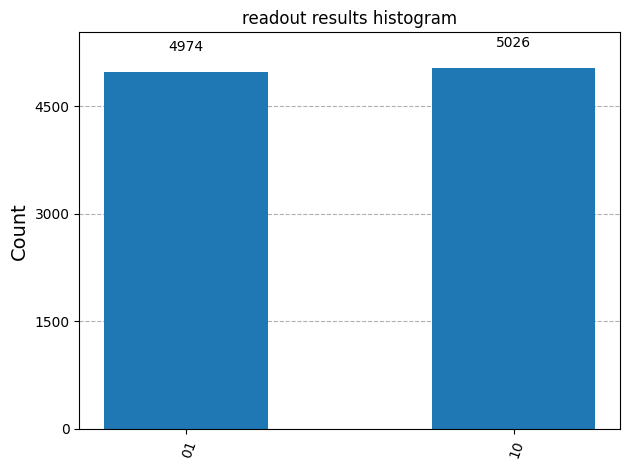

In [28]:
# Creating Psi+

def psi_plus_prep():
    psi_plus_circ = QuantumCircuit(2)

    """Complete the code"""
    qc = psi_plus_circ
    qc.h(0)
    qc.cx(0, 1)
    qc.x(0) # qc.x(1) also works the same
    """End"""
    return psi_plus_circ

# to see the measurement result and draw the circuit
qc = QuantumCircuit(2, 2)
qc = qc.compose(psi_plus_prep()).compose(two_qubit_measurement_circuit())
qc.draw()
show_info(qc)

### Exercise: Create $\Psi^-$ State

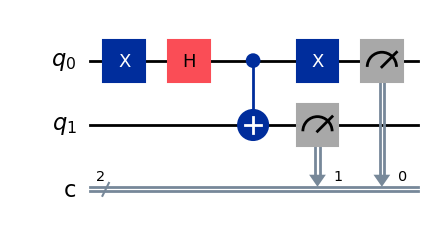

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


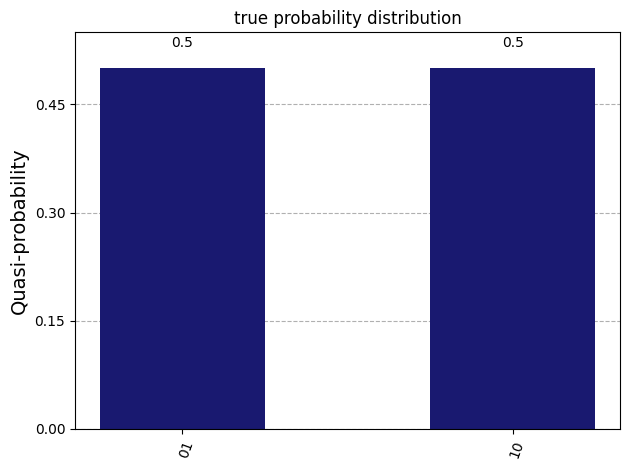

====== counts from measurements ======


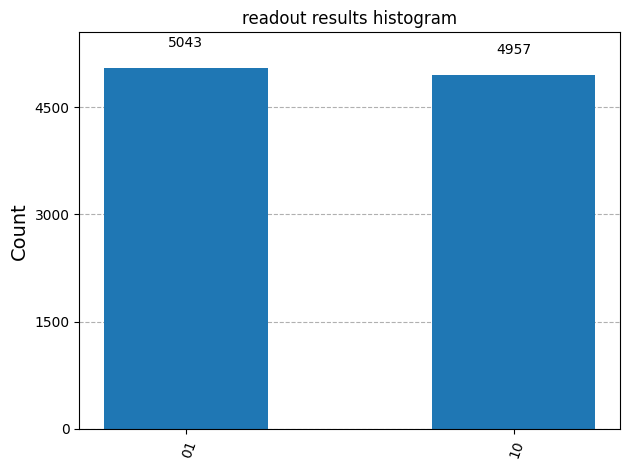

In [29]:
# Creating Psi+

def psi_minus_prep():
    psi_minus_circ = QuantumCircuit(2)

    """Complete the code"""
    psi_minus_circ = QuantumCircuit(2)

    """Complete the code"""
    # Other method in answer sheet
    qc = psi_minus_circ
    qc.x(0)
    qc.h(0)
    qc.cx(0, 1)
    qc.x(0) # qc.x(1) also works the same
    """End"""
    return psi_minus_circ

# to see the measurement result and draw the circuit
qc = QuantumCircuit(2, 2)
qc = qc.compose(psi_minus_prep()).compose(two_qubit_measurement_circuit())
qc.draw()
show_info(qc)


## Bell state analyzer
---

Suppose we have a Bell pair but we don't know which of the 4 possible states they are in, we can recognize them by performing a certain kind of measurement call the **Bell Measurement** (which we have learned from lesson 13 step 2 of the video). Remember that in Qiskit, we can only perform measurement in Z basis (the computational basis), our job is to implement the unitary to change the Bell basis into Z-basis

We want to interpret each form as the Bell state as the table below.

| Bell state                          |   q0,q1 (eigenvalues) | output from the circuit |
|---------                            |--------------         | -------------           |
| $\left\vert\Phi^{+}\right\rangle$   | +1,+1                 | 00                      |
| $\left\vert\Phi^{-}\right\rangle$   | +1,-1                 | 01                      |
| $\left\vert\Psi^{+}\right\rangle$   | -1,+1                 | 10                      |
| $\left\vert\Psi^{-}\right\rangle$   | -1,-1                 | 11                      |


**The table above is just one valid mapping, any 1-1 mapping from the 4 Bell States to the 4 computational bases works the same.**

### Additional Note

if you're familiar with linear algebra, you may recall that the unitary we need to implement is the same as implementing the change of basis matrix.
Learn more about change of basis from this great [youtube video.](https://youtu.be/P2LTAUO1TdA)

### Exercise: create BSA circuit

Note: Don't add the measurement to this BSA component, we'll add the measurement part later in another component

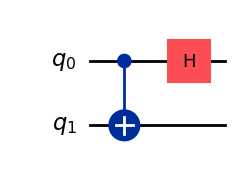

In [30]:
def bell_state_analyser():

    bell_state_analyser_circuit = QuantumCircuit(2)

    """Complete the code"""
    bell_state_analyser_circuit.cx(0, 1)
    bell_state_analyser_circuit.h(0)
    """End"""
    return bell_state_analyser_circuit.remove_final_measurements(inplace=False)

bell_state_analyser().draw()

### Testing BSA circuit we just made

Let's test if it works as intended, it should output the same measurement result as the table above.
**No need to modify the 4 code blocks below.**

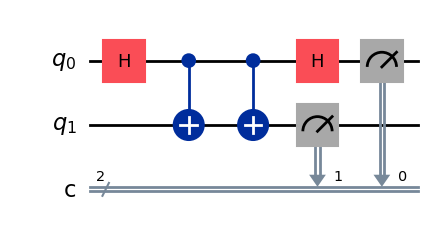

None

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


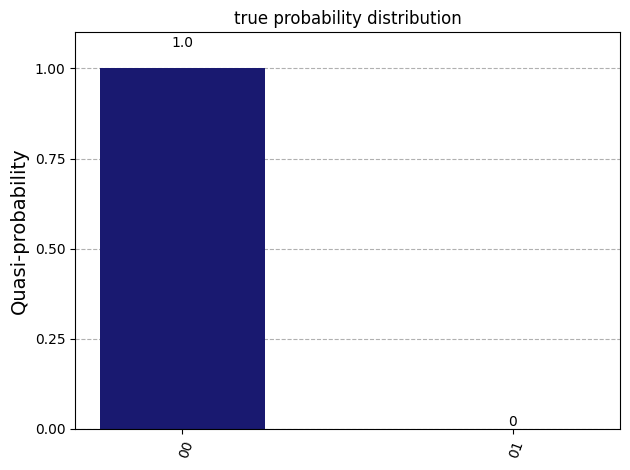

====== counts from measurements ======


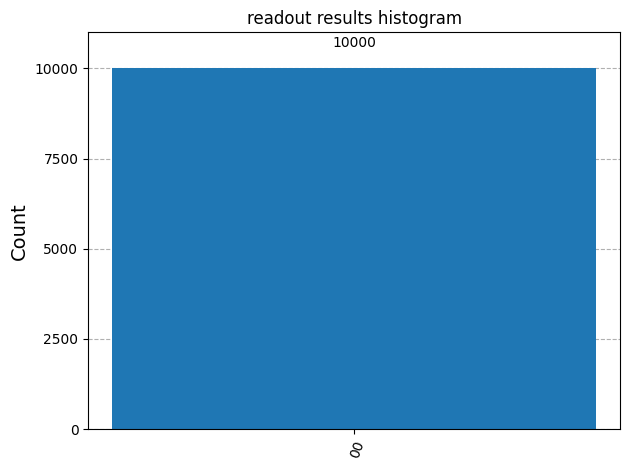

In [31]:
## Test with Phi+

qc = QuantumCircuit(2, 2)
qc = qc.compose(phi_plus_prep()).compose(bell_state_analyser()).compose(two_qubit_measurement_circuit())
display(qc.draw())
show_info(qc)

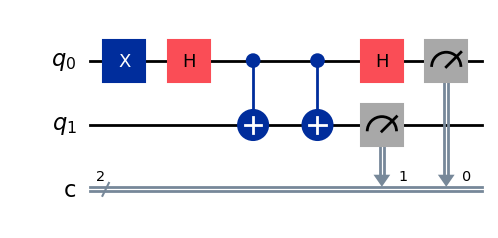

None

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


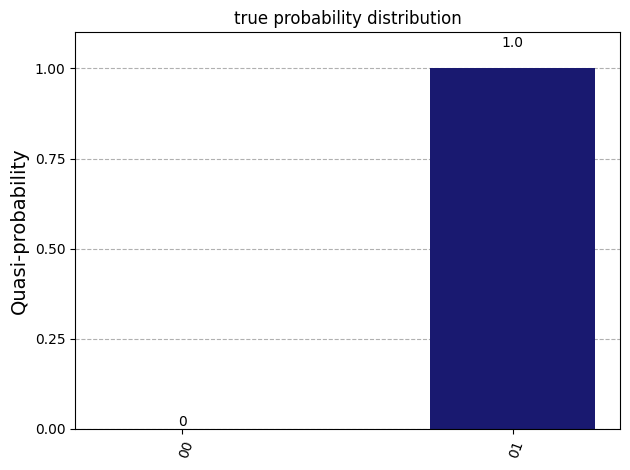

====== counts from measurements ======


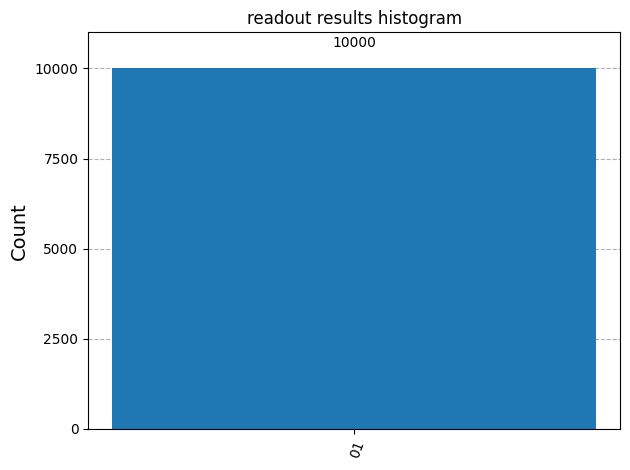

In [32]:
## Test with Phi-

qc = QuantumCircuit(2, 2)
qc = qc.compose(phi_minus_prep()).compose(bell_state_analyser()).compose(two_qubit_measurement_circuit())
display(qc.draw())
show_info(qc)

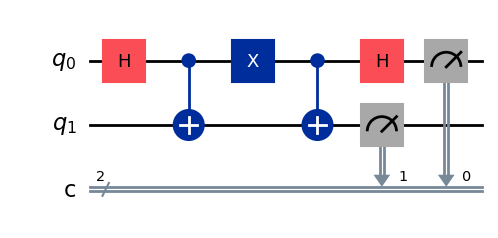

None

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


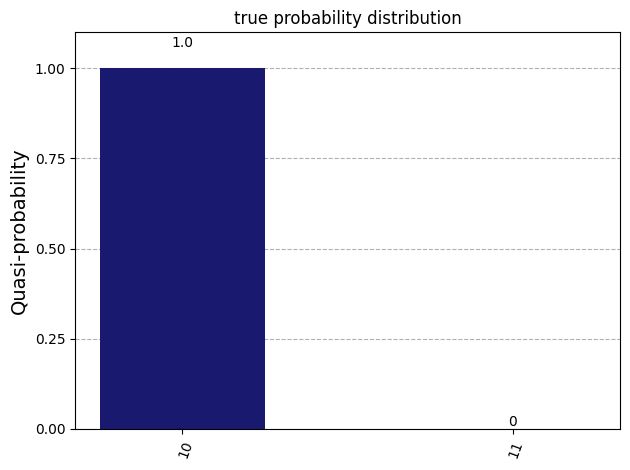

====== counts from measurements ======


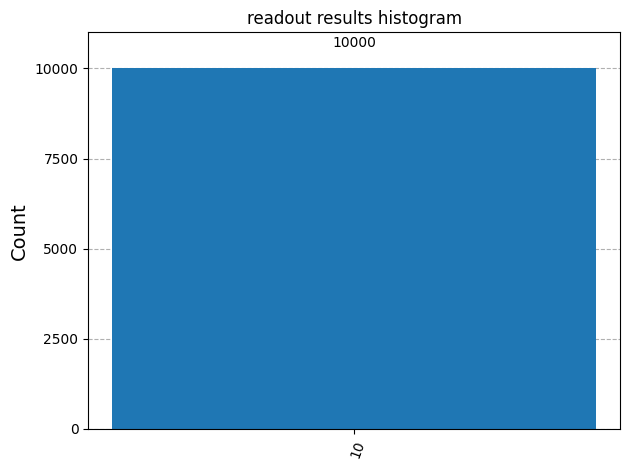

In [33]:
## Test with Psi+

qc = QuantumCircuit(2, 2)
qc = qc.compose(psi_plus_prep()).compose(bell_state_analyser()).compose(two_qubit_measurement_circuit())
display(qc.draw())
show_info(qc)

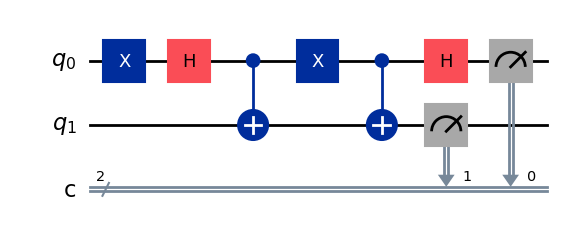

None

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


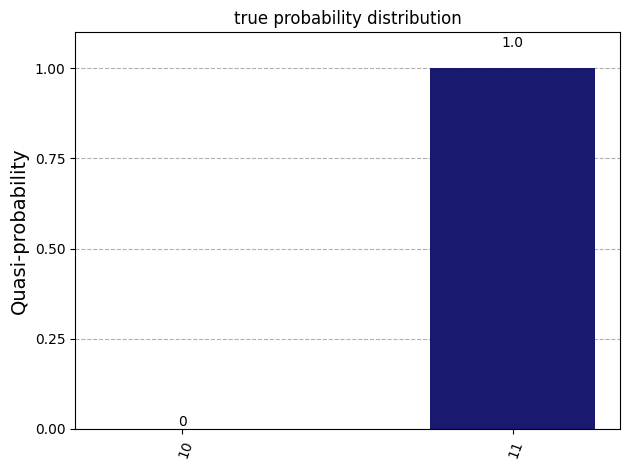

====== counts from measurements ======


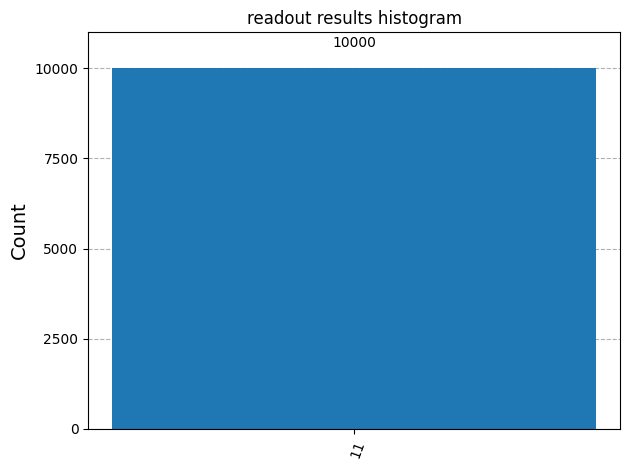

In [34]:
## Test with Psi-

qc = QuantumCircuit(2, 2)
qc = qc.compose(psi_minus_prep()).compose(bell_state_analyser()).compose(two_qubit_measurement_circuit())
display(qc.draw())
show_info(qc)

**Does the output of the 4 circuits for distinguishing each variation of Bell State correct?**

# Teleportation

---

You may have heard about teleportation, moving object from one place to another in space and it was done instantaneously! Unfortunately or maybe fortunately depending on who you are, quantum teleportation isn't instantaneous and it doesn't move object but moving quantum data. And to say move is not technically right, quantum teleportation **destroys** the quantum state at one place and **recreate** that same state in a different place, moving data from one qubit to another qubit by consuming one Bell pair. This does **NOT** violate the faster-than-light communication which we will see why in a bit.

Let say we have two people Alice and Bob. Alice and Bob already share a Bell pair created sometime earlier. Now Alice have a qubit that she wants to send to Bob (sending the qubit state to Bob). She can do so by applying Bell measurement, the Bell state analyzer we used earlier, to her data qubit and her half of the Bell pair she has with Bob. After she has done the measurement, she needs to send the measurement results to Bob via some means. Once Bob receives the message from Alice saying that she already performed her part of the task, Bob can use the information and apply an operation (Pauli correction or correction frame) to his half of the destroyed Bell pair and the state which Alice held earlier will appear in Bob's qubit. This concludes the teleportaion procedure.

Let's analysize what was going on in each step above.

1. Alice and Bob must share a Bell pair. (in our example we will say that they share a $\Phi_+$ state)
1. Alice prepares a data qubit. $\ket{\Psi} = \alpha \ket{0} + \beta \ket{1}$
1. Alice performs a Bell measurement on her half of the Bell pair and the data qubit.

<!-- Let's pause here for a bit and write the states out and for simplicity of writing we will drop the $1 / \sqrt{2}$ in factor of the Bell state

$\begin{aligned}
\ket{0_A 0_B} + \ket{1_A 1_B}
\\
\ket{\Psi} \otimes \left(\ket{0_A 0_B} + \ket{1_A 1_B}\right)
\\
( \alpha \ket{0_{A'}} + \beta \ket{1_{A'}} ) \otimes \left(\ket{0_A 0_B} + \ket{1_A 1_B}\right)
\\
( \alpha \ket{0_{A'}} + \beta \ket{1_{A'}} ) \otimes \left(\ket{0_A 0_B} + \ket{1_A 1_B}\right)
\\
\alpha \ket{0_{A'}} \otimes \left(\ket{0_A 0_B} + \ket{1_A 1_B}\right) + \beta \ket{1_{A'}}\otimes \left(\ket{0_A 0_B} + \ket{1_A 1_B}\right)
\\
\alpha \ket{0_{A'} 0_A 0_B} + \alpha \ket{0_{A'} 1_A 1_B} + \beta \ket{1_{A'} 0_A 0_B} + \beta \ket{1_{A'} 1_A 1_B}
\end{aligned}$ -->

Let's pause here for a bit and write the total initial state out

$\begin{aligned}|\psi\rangle_{A_{1}}\left|\Phi^{+}\right\rangle_{A_{2} B} &=(\alpha|0\rangle+\beta|1\rangle)_{A_{1}} \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)_{A_{2} B} \\ &=\frac{1}{\sqrt{2}}(\alpha|000\rangle+\alpha|011\rangle+\beta|100\rangle+\beta|111\rangle)_{A_{1} A_{2} B} \end{aligned}$

We know that we can write the 4 Bell states in the computational basis as

$\left|\Phi^{+}\right\rangle=\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle) \quad\left|\Phi^{-}\right\rangle=\frac{1}{\sqrt{2}}(|00\rangle-|11\rangle)$
$\left|\Psi^{+}\right\rangle=\frac{1}{\sqrt{2}}(|01\rangle+|10\rangle) \quad\left|\Psi^{-}\right\rangle=\frac{1}{\sqrt{2}}(|01\rangle-|10\rangle)$

Then if we instead write the computational basis states in Bell basis

$\begin{array}{ll}|00\rangle=\frac{1}{\sqrt{2}}\left(\left|\Phi^{+}\right\rangle+\left|\Phi^{-}\right\rangle\right) & |01\rangle=\frac{1}{\sqrt{2}}\left(\left|\Psi^{+}\right\rangle+\left|\Psi^{-}\right\rangle\right) \\ |10\rangle=\frac{1}{\sqrt{2}}\left(\left|\Psi^{+}\right\rangle-\left|\Psi^{-}\right\rangle\right) & |11\rangle=\frac{1}{\sqrt{2}}\left(\left|\Phi^{+}\right\rangle-\left|\Phi^{-}\right\rangle\right)\end{array}$

Using above trick, we can rewrite the states as

$\begin{aligned}|\psi\rangle_{A_{1}}\left|\Phi^{+}\right\rangle_{A_{2} B}=&(\alpha|0\rangle+\beta|1\rangle)_{A_{1}} \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)_{A_{2} B} \\=& \frac{1}{\sqrt{2}}(\alpha|000\rangle+\alpha|011\rangle+\beta|100\rangle+\beta|111\rangle)_{A_{1} A_{2} B} \\=& \frac{1}{\sqrt{2}}\left(\alpha\left(\left|\Phi^{+}\right\rangle+\left|\Phi^{-}\right\rangle\right)|0\rangle\right.\\ &+\alpha\left(\left|\Psi^{+}\right\rangle+\left|\Psi^{-}\right\rangle\right)|1\rangle \\ &+\beta\left(\left|\Psi^{+}\right\rangle-\left|\Psi^{-}\right\rangle\right)|0\rangle \\ &+\beta\left(\left|\Phi^{+}\right\rangle-\left|\Phi^{-}\right\rangle\right)|1\rangle \end{aligned}$

And after a little regrouping and rewriting again, we get

$\begin{aligned}|\psi\rangle_{A_{1}}\left|\Phi^{+}\right\rangle_{A_{2} B} &=\frac{1}{2}\left|\Phi^{+}\right\rangle_{A_{1} A_{2}}(\alpha|0\rangle+\beta|1\rangle)_{B} \\ &+\frac{1}{2}\left|\Phi^{-}\right\rangle_{A_{1} A_{2}}(\alpha|0\rangle-\beta|1\rangle)_{B} \\ &+\frac{1}{2}\left|\Psi^{+}\right\rangle_{A_{1} A_{2}}(\alpha|1\rangle+\beta|0\rangle)_{B} \\ &+\frac{1}{2}\left|\Psi^{-}\right\rangle_{A_{1} A_{2}}(\alpha|1\rangle-\beta|0\rangle)_{B} \end{aligned}$

So we can see here that each outcome of the 4 Bell basis states are equally likely. And depending on what Alice gets, the state at Bob will be off by only either a bit flip, a phase flip, or both.

And remember that we haven't really done anything to the states, we were just rewriting and regrouping the terms!

## Is Teleportation instantaneous?

Initially, Bob has one qubit and from his view point it's in the state

$\left|\Phi^{+}\right\rangle_{A_{2} B}=\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle) \longrightarrow \rho_{B}=\frac{1}{2}|0\rangle\left\langle 0\left|+\frac{1}{2}\right| 1\right\rangle\langle 1|$

which is a maximally mixed state.

Then just before Alice performs the measurement, the state is in

$\frac{1}{2}\left|\Phi^{+}\right\rangle_{A_{1} A_{2}}(\alpha|0\rangle+\beta|1\rangle)_{B}+\frac{1}{2}\left|\Phi^{-}\right\rangle_{A_{1} A_{2}}(\alpha|0\rangle-\beta|1\rangle)_{B}$
$+\frac{1}{2}\left|\Psi^{+}\right\rangle_{A_{1} A_{2}}(\alpha|1\rangle+\beta|0\rangle)_{B}+\frac{1}{2}\left|\Psi^{-}\right\rangle_{A_{1} A_{2}}(\alpha|1\rangle-\beta|0\rangle)_{B}$

But what about Bob's state just right after the measurement?

$\operatorname{Prob}\left(\left|\Phi^{+}\right\rangle\right)=1 / 4, \quad$ Bob has $\alpha|0\rangle+\beta|1\rangle$
$\operatorname{Prob}\left(\left|\Phi^{-}\right\rangle\right)=1 / 4, \quad$ Bob has $\alpha|0\rangle-\beta|1\rangle$
$\operatorname{Prob}\left(\left|\Psi^{+}\right\rangle\right)=1 / 4, \quad$ Bob has $\alpha|1\rangle+\beta|0\rangle$
$\operatorname{Prob}\left(\left|\Psi^{-}\right\rangle\right)=1 / 4, \quad$ Bob has $\alpha|1\rangle-\beta|0\rangle$

So if we look at Bob's viewpoint again on the state he's holding

$\begin{aligned} \rho_{B} &=\frac{1}{4}(\alpha|0\rangle+\beta|1\rangle)\left(\alpha^{*}\langle 0|+\beta^{*}\langle 1|\right) \\ &+\frac{1}{4}(\alpha|0\rangle-\beta|1\rangle)\left(\alpha^{*}\langle 0|-\beta^{*}\langle 1|\right) \\ &+\frac{1}{4}(\alpha|1\rangle+\beta|0\rangle)\left(\alpha^{*}\langle 1|+\beta^{*}\langle 0|\right) \\ &+\frac{1}{4}(\alpha|1\rangle-\beta|0\rangle)\left(\alpha^{*}\langle 1|-\beta^{*}\langle 0|\right) \end{aligned}$

then

$\begin{aligned} \rho_{B} &=\frac{1}{2}\left(|\alpha|^{2}+|\beta|^{2}\right)|0\rangle\langle 0| \\ &+\frac{1}{2}\left(|\alpha|^{2}+|\beta|^{2}\right)|1\rangle\langle 1| \\ &=\frac{1}{2}|0\rangle\left\langle 0\left|+\frac{1}{2}\right| 1\right\rangle\langle 1| \end{aligned}$

Which is still a maximally mixed state!

So the teleportation hasn't taken placed yet just after Alice performing the measurement.

Even when Alice sends the results, the measurement still hasn't taken place until Bob finally gets the results. At that point then we can say that the teleporation has finally taken place.

**So teleportation doesn't violate the faster-than-light communication restriction because the Pauli correction message speed is still limited by the speed of light.**

Now that we understand the theory behind the teleportation procedure, let's try to simulate it in the circuit form.

### Exercise: Initialize Alice's data qubit

Let's try to pick some random state with non-uniform superposition of $\ket{0}$ and $\ket{1}$ by using Ry gate.
Try and pick $\theta$ you want and we will use this same state for Alice in our teleportation circuit.

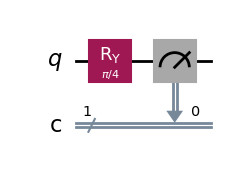

None

====== state_vector ======


<IPython.core.display.Latex object>


====== true probability distribution =====


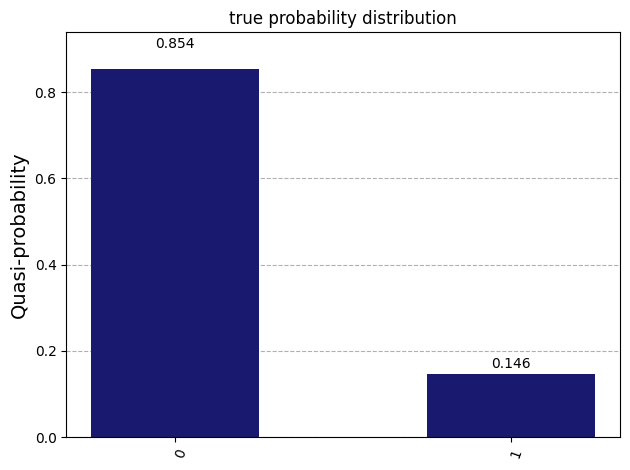

====== counts from measurements ======


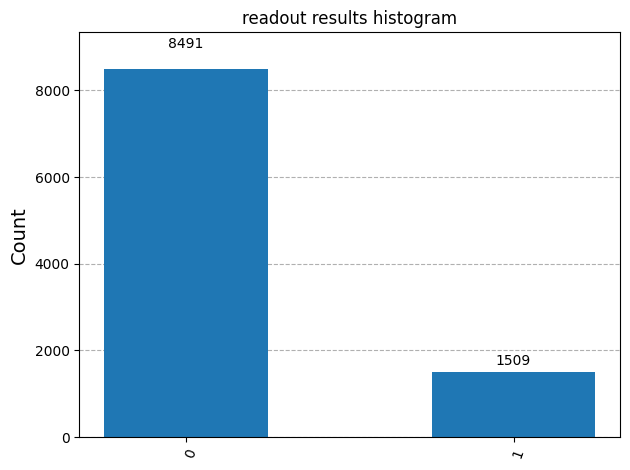

In [42]:
alice_qubit_circ = QuantumCircuit(1, 1)

"""Choose your own theta"""
## Begin
# Change 0 to your value of choice!

theta = np.pi/4

## End


alice_qubit_circ.ry(theta, 0)
alice_qubit_circ.measure(0, 0)

display(alice_qubit_circ.draw())
show_info(alice_qubit_circ, use_statevector_only=True)

### Exercise: Initialize Alice's data qubit using the $\theta$ we picked

This time we will use register naming approach to create the circuit so we get a clearer picture of whose qubits are we working on.

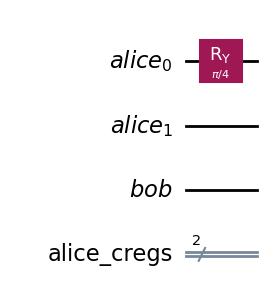

In [43]:
def alice_bob_preparation():
    # Creating Alice and Bob registers
    alice = QuantumRegister(2, "alice")
    bob = QuantumRegister(1, "bob")
    creg = ClassicalRegister(2, "alice_cregs") # So we can see the results
    return alice, bob, creg, QuantumCircuit(alice, bob, creg)


def prepare_alice_qubit():
    alice, _, _, qc = alice_bob_preparation()
    """Complete the Code below"""
    # pick your theta and apply it again here.
    # reminder if you want to apply x on alice's data qubit it can be done via qc.x(alice[0])

    qc.ry(np.pi/4, 0)
    """End"""
    return qc

prepare_alice_qubit().draw()

### Exercise: Create a Bell pair between Alice and Bob

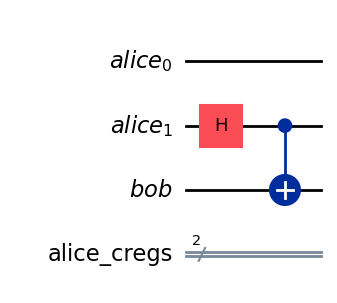

In [44]:
def prepare_bell_pair_between_alice_and_bob():
    alice, bob, _, qc = alice_bob_preparation()
    """Complete the Code below"""
    qc.h(alice[1])
    qc.cx(alice[1], bob[0])

    """End"""
    return qc


prepare_bell_pair_between_alice_and_bob().draw()

### Exercise: Perform Bell state measurement on Alice's qubits

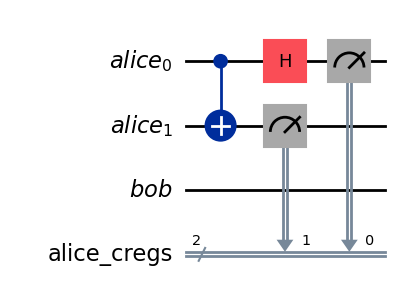

In [45]:
def perform_bsa_on_alice_qubits():
    alice, bob, creg, qc = alice_bob_preparation()
    """Complete the Code below"""
    # make sure to store the results into classical registers

    # In short, it's the same steps as before but inverted
    qc.cx(alice[0], alice[1])
    qc.h(alice[0])
    qc.measure([alice[0], alice[1]], [creg[0], creg[1]])

    """End"""
    return qc

perform_bsa_on_alice_qubits().draw()

### Exercise: Apply Pauli correction on Bob's qubit

So far we've only done measurement at the very end of a circuit. It should be noted that it is possible to perform a measurment in the middle of the circuit and depending on the classical readout make a decision on what to perform next based on that. This is referred to as feed-forward operation.

Noted that this feed-forward is not available on most real devices yet.

To append a gate based on values inside classical register, it can be done using `if_test` block. The syntax is
with `qc.if_test((<creg_bit>, <creg_value>)):` followed by the gate you want to apply inside the block.
For example if we want to apply X to Alice's data qubit (qubit 0) if data in creg[1] equals 1, we can do so by `with qc.if_test((creg[1], 1)): qc.x(alice[0])`

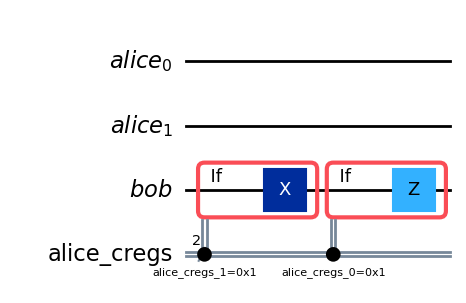

In [46]:
def bob_apply_corrections():
    alice, bob, creg, qc = alice_bob_preparation()
    """Complete the Code below"""
    # Remember the creg indexing you store the BSA results to, and apply the conditional gate on the correct index.
    # example, if you want to perform X on q[0] if result of c[2] is 1, you can do:
    # with qc.if_test((c[2], 1)):
    #     qc.x(q[0])

    with qc.if_test((creg[1], 1)):
        qc.x(bob[0])

    with qc.if_test((creg[0], 1)):
        qc.z(bob[0])

    """End"""
    return qc


bob_apply_corrections().draw()

### Let's look at the whole circuit we just create before verifying it.

Barriers are inserted (dashed vertical lines) to separate each step.

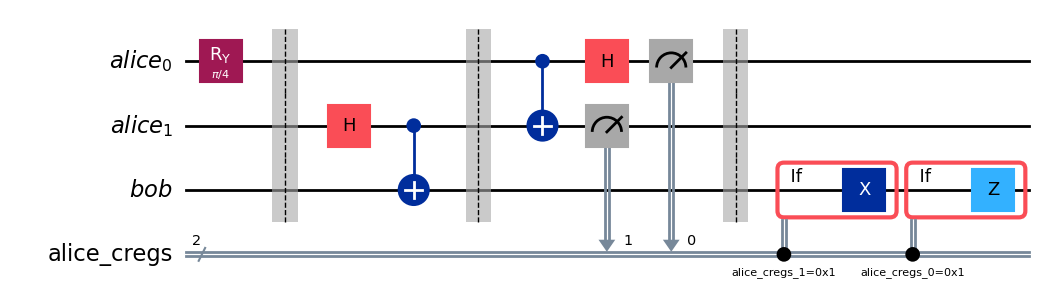

In [47]:
qc = prepare_alice_qubit()
qc.barrier()
qc = qc.compose(prepare_bell_pair_between_alice_and_bob())
qc.barrier()
qc = qc.compose(perform_bsa_on_alice_qubits())
qc.barrier()
qc = qc.compose(bob_apply_corrections())
qc.draw()

### Exercise: Verify if our teleportation procedure is correct or not!

If everything we've done so far is correct we should see two statevector plots / state equations to be the same
and a message confirming the results at the end of the output.

alice state vector = Statevector([0.92387953+0.j, 0.38268343+0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j],
            dims=(2, 2, 2))
bob state vector = Statevector([0.92387953+0.00000000e+00j, 0.38268343-4.68652041e-17j],
            dims=(2,))
Congratulations! You made the teleportation works!


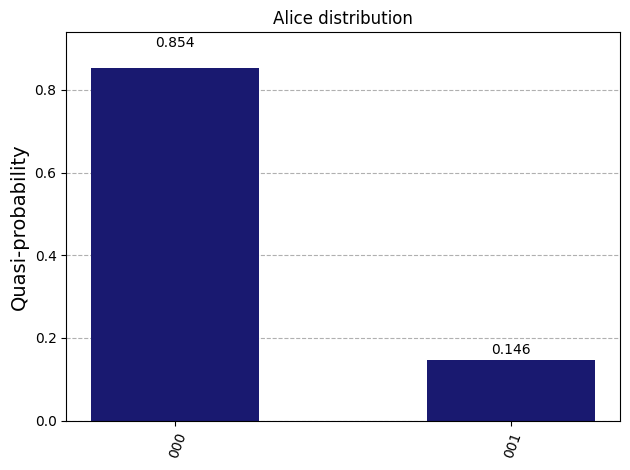

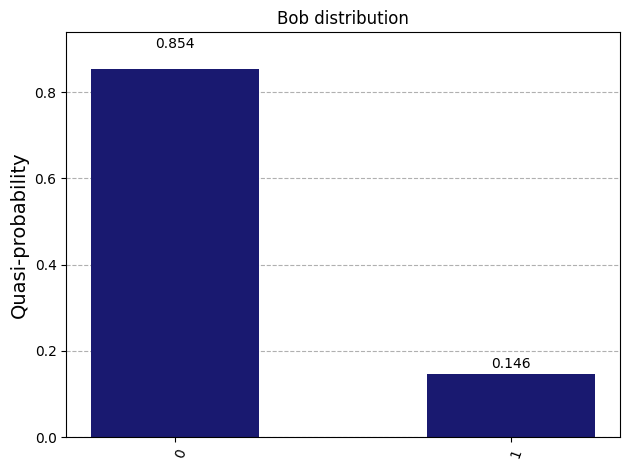

In [48]:
# check equal ignore global phase via statevector method
alice_data_qubit_sv = sv_sim.run(prepare_alice_qubit().remove_final_measurements(inplace=False)).result().get_statevector()
whole_circuit_sv = sv_sim.run(prepare_alice_qubit()
                              .compose(prepare_bell_pair_between_alice_and_bob())
                              .compose(perform_bsa_on_alice_qubits())
                              .compose(bob_apply_corrections())).result().get_statevector()
alice_initial_qubit_sv = partial_trace(alice_data_qubit_sv, [1, 2]).to_statevector()
bob_final_qubit_sv = partial_trace(whole_circuit_sv, [0, 1]).to_statevector()
print(f'alice state vector = {alice_data_qubit_sv.draw()}')
print(f'bob state vector = {bob_final_qubit_sv.draw()}')
if bob_final_qubit_sv.equiv(alice_initial_qubit_sv):
    print('Congratulations! You made the teleportation works!')
else:
    print('You probably made something wrong!')

display(plot_histogram({k: np.abs(v) ** 2 for k, v in alice_data_qubit_sv.to_dict().items()}, title='Alice distribution', color='midnightblue'))
display(plot_histogram({k: np.abs(v) ** 2 for k, v in bob_final_qubit_sv.to_dict().items()}, title='Bob distribution', color='midnightblue'))


# Entanglement Swapping

---

Entanglment swapping is the heart of quantum network protocols. It is used to create long distance Bell pairs.

A simple but not quite accurate description of it is that if we have two Bell pairs where one person is holding one end of both pairs, they can stitch the Bell pair together creating a longer Bell pair.


Let say we have three people, Alice, Bob and Clare.


Both Alice and Clare create create a Bell pair each, they send one qubit of their Bell pair to Bob.


Bob then performs a Bell state measurement and send the measurement result to Alice or Clare or both so that the two can apply corrections on their qubits if needed.


This results is used to select which unitary (x, z) is used on, say Alice's, initial qubit. Doing so, entangling Alice's qubit with Clare's initial one.

It looks like what Bob did was to stitch the two pairs together, but what actually happens is that Bob performs teleportation on Alice's (or Clare's qubit) to Clare's (Alice's).


### Noted
You should write all the operations, Bell state creation, Bell state analyzer from scratch here to help improve and test your understanding from above exercises.

### Exercise Complete the code block below

In [49]:
#Create the initial state
alice = QuantumRegister(1, "alice")
bob = QuantumRegister(2, "bob")
clare = QuantumRegister(1, "clare")
creg = ClassicalRegister(2)  # Classical Register to store Bob's measurement results
qc = QuantumCircuit(alice, bob, clare, creg)


# Make entanglement between Alice-Bob
"""Write your code here"""
qc.h(alice[0])
qc.cx(alice[0], bob[0])

# Make entanglement between Bob-Clare
"""Write your code here"""
qc.h(bob[1])
qc.cx(bob[1], clare[0])


# Bob applies BSA on his qubits
"""Write your code here"""
qc.cx(bob[0], bob[1])
qc.h(bob[0])


# Bob measures his qubits
"""Write your code here"""
qc.measure(bob[0], creg[0])
qc.measure(bob[1], creg[1])


# Bob sends out his results. Use if_test() to simulate the idea of receiving the results and apply the correction for it
"""Write your code here"""
with qc.if_test((creg[0], 1)):
    qc.z(alice[0])
with qc.if_test((creg[1], 1)):
    qc.x(alice[0])


### Exercise: Add code to measure out the two remaining qubits. Do the results match what you expect?

Run the code below to see if the final state between Alice and Clare is actually a $\ket{\Phi}^+$ Bell pair.

Congratulations! You made the entanglement swapping works!


<IPython.core.display.Latex object>

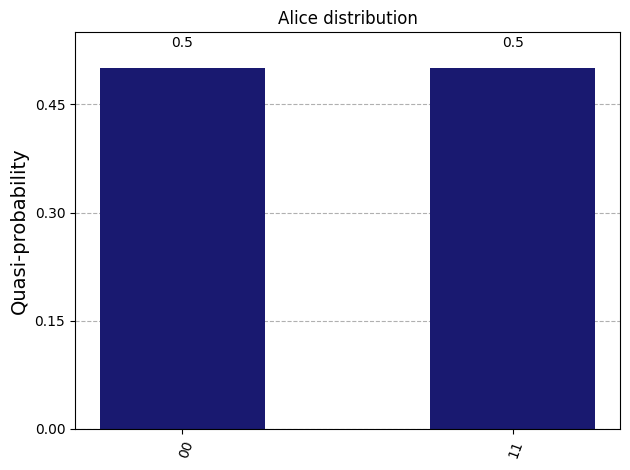

In [51]:
# check equal ignore global phase via statevector method

final_sv = sv_sim.run(qc).result().get_statevector()
phi_plus_sv = sv_sim.run(phi_plus_prep()).result().get_statevector()
alice_clare_sv = partial_trace(final_sv, [1, 2]).to_statevector()

if alice_clare_sv.equiv(phi_plus_sv):
    print('Congratulations! You made the entanglement swapping works!')
else:
    print('You probably made something wrong!')

display(alice_clare_sv.draw(output='latex'))
display(plot_histogram({k: np.abs(v) ** 2 for k, v in alice_clare_sv.to_dict().items()}, title='Alice distribution', color='midnightblue'))

# Purification (Error Detection)


---
Purification is a form of error detection.

Due to the imperfection in the process of geneting an entangled pair (Bell pair) and the noise from the environment which can affect and change the state of our Bell pair. The more imperfection in our generation process and the longer we keep the Bell pair in our memories, the less sure we are about the actual Bell pair states.

To increase our confidence that the Bell pair is still in the state we are expecting it to be, we can use purification process, which consumes 1 or more Bell pairs in order to find out whether our Bell pair in question is still in the correct state or not.

It is an error detection process because, when we perform the purification protocol, it either tells us whether our Bell pair is likely in the correct state or it doesn't. It doesn't tell us about which error (e.g., bit flip, phase flip) happened.

## Adding noise to our Bell pairs

As we mentioned earlier, Bell pairs aren't always perfect. We can simulate the idea that 80% of the times our Bell pairs are in the $\ket{\Phi_+}$ state and 20% of the times an X error occurs, so it becomes $\ket{\Psi_+}$ state.

We already provide a custom gate called `noisyCX()` which 20% of the times it automatically adds X gate on the control bit.

If we build our Bell pair using this `noisyCX()` we can simulate the effect of noisy (mixed state) Bell pair.

{'11': 4025, '01': 1002, '10': 925, '00': 4048}


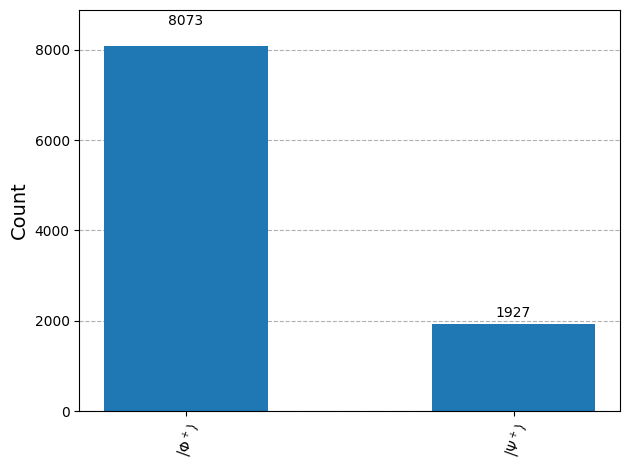

In [52]:
"""How we define noisy CX gate"""
noise_rate = 0.2
def noisyCX(self, a, b):
    self.cx(a, b)
    self.id(b)

QuantumCircuit.noisyCX = noisyCX

p_error = 0.2 # 20% cnot error
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(bit_flip, "id")
noisy_sim = AerSimulator(noise_model=noise_bit_flip)
"""END"""

def sample_faulty_bell_pair():
    counts = {}
    counts[f'$| \\Phi^+ \\rangle $'] = 0
    counts[f'$| \\Psi^+ \\rangle $'] = 0

    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.noisyCX(0, 1)
    qc.measure([0, 1], [0, 1])
    str_counts = noisy_sim.run(qc, shots=10_000).result().get_counts()
    counts[f'$| \\Phi^+ \\rangle $'] = str_counts['00'] + str_counts['11']
    print(str_counts)

    if '01' in str_counts:
        counts[f'$| \\Psi^+ \\rangle $'] += str_counts['01']
    if '10' in str_counts:
        counts[f'$| \\Psi^+ \\rangle $'] += str_counts['10']
    return counts

counts = sample_faulty_bell_pair()
plot_histogram(counts)

### Exercise: Create 2 Bell pairs using the NoisyCX

Complete the Bell pair creation circuit

**NOTE**: this circuit creation function is probabilistic, 20% of the times and X gate is added so try running it multiple times to see if the result changes or not!

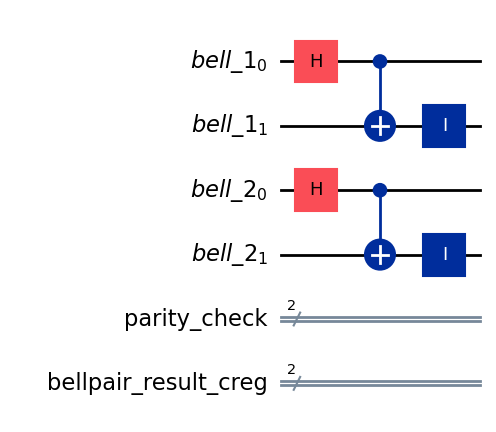

In [53]:
bp1 = QuantumRegister(2, 'bell_1')
bp2 = QuantumRegister(2, 'bell_2')
parity_check_creg = ClassicalRegister(2, 'parity_check')
bell_pair_creg = ClassicalRegister(2, 'bellpair_result_creg')


def prepare_two_noisy_bellpair():
    noisy_2_bp_circ = QuantumCircuit(bp1, bp2, parity_check_creg, bell_pair_creg)
    ### Complete the code here to create 2 Bell pairs using NoisyCX
    # noisy_2_bp_circ.noisyCX(x, y)

    # Bell pair 1
    noisy_2_bp_circ.h(bp1[0])
    noisy_2_bp_circ.noisyCX(bp1[0], bp1[1])
    # Bell pair 2
    noisy_2_bp_circ.h(bp2[0])
    noisy_2_bp_circ.noisyCX(bp2[0], bp2[1])



    ### END
    return noisy_2_bp_circ



qc = QuantumCircuit(bp1, bp2, parity_check_creg, bell_pair_creg)
qc = qc.compose(prepare_two_noisy_bellpair())
# qc.measure([bp1[0], bp2[0], bp1[1], bp2[1]], [*bell_pair_creg, *parity_check_creg])
qc.draw()

### Note on the Exercise

If you see the "I" or idendity gate added to one qubit of the Bell pairs, you have created the noisy Bell pairs correctly. These identity gates are defined to probabilistically add bit flip 20% of the times

### Exercise: Create Purification Circuit

We want to check the parity of the 1st Bell pair, and consume the 2nd Bell pair for parity check.

**NOTE: We want to use _IDEAL_ non-noisy CX for this case**

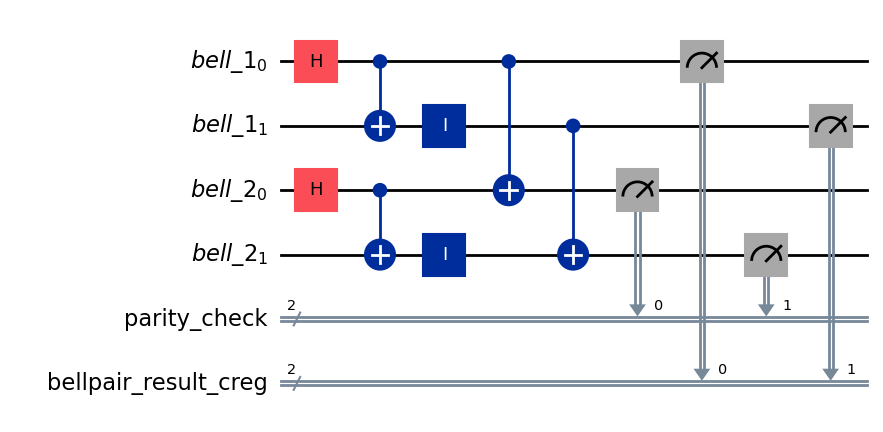

In [54]:
bp1 = QuantumRegister(2, 'bell_1')
bp2 = QuantumRegister(2, 'bell_2')
parity_check_creg = ClassicalRegister(2, 'parity_check')
bell_pair_creg = ClassicalRegister(2, 'bellpair_result_creg')
purification_circ = QuantumCircuit(bp1, bp2, parity_check_creg, bell_pair_creg)

# purification_circ
# qc.cx ...
purification_circ.cx(bp1[0], bp2[0])
purification_circ.cx(bp1[1], bp2[1])

## Perform the measurement on 2nd bell pair
purification_circ.measure(bp2[0], parity_check_creg[0])
purification_circ.measure(bp2[1], parity_check_creg[1])

### END

qc = QuantumCircuit(bp1, bp2, parity_check_creg, bell_pair_creg)
qc = qc.compose(prepare_two_noisy_bellpair()).compose(purification_circ)
qc.measure([*bp1], [*bell_pair_creg])
qc.draw()


### Exercise: Complete the code block below to check if purification procedure succeed or fail

In [55]:
def is_purification_successful():
    qc = QuantumCircuit(bp1, bp2, parity_check_creg, bell_pair_creg)
    qc = qc.compose(prepare_two_noisy_bellpair()).compose(purification_circ)
    qc.measure([*bp1], [*bell_pair_creg])

    job = noisy_sim.run(qc, shots=1)
    cnt = job.result().get_counts()
    parity_check_value_str = list(cnt.keys())[0][3:]
    ### Complete the code here

    ## Make sure that success is assign a Boolean value (True, False)
    ## since we already make a meausrment to  use the value inside that!
    ## use value inside parity_check_value_str, it'll be in either
    ## '00', '01', '10', '11'

    success = parity_check_value_str[0] == parity_check_value_str[1]

    ### END
    return success, list(cnt.keys())[0][:2] # return success/failure + bp results

### Testing code
if type(is_purification_successful()[0]) == bool:
    print(f'Your code is probably correct!')
else:
    print(f'Your code might not be correct!')

Your code is probably correct!


### Exercise: The only thing left to do is test!

After adding the measurement to first Bell pair, try running the code below.

What it does is it tries to gather 10,000 successful purification runs and gather statistics on the readout of the first Bell pair. Noted that earlier when we didn't perform purification process, the Bell pairs were correct 80% of the time. Now we should see and increase in the fidelity (higher chance of seeing correct state).

The output also shows how many runs we actually did to gather the 10,000 purifed Bell pairs. Since purification is a probabilitic process, we see that sometimes it fails and sometimes it succeed.

<>:4: SyntaxWarning: invalid escape sequence '\P'
<>:5: SyntaxWarning: invalid escape sequence '\P'
<>:17: SyntaxWarning: invalid escape sequence '\P'
<>:17: SyntaxWarning: invalid escape sequence '\P'
<>:19: SyntaxWarning: invalid escape sequence '\P'
<>:19: SyntaxWarning: invalid escape sequence '\P'
<>:4: SyntaxWarning: invalid escape sequence '\P'
<>:5: SyntaxWarning: invalid escape sequence '\P'
<>:17: SyntaxWarning: invalid escape sequence '\P'
<>:17: SyntaxWarning: invalid escape sequence '\P'
<>:19: SyntaxWarning: invalid escape sequence '\P'
<>:19: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipython-input-4062660389.py:4: SyntaxWarning: invalid escape sequence '\P'
  counts[f'$\Phi+$'] = 0
/tmp/ipython-input-4062660389.py:5: SyntaxWarning: invalid escape sequence '\P'
  counts[f'$\Psi+$'] = 0
/tmp/ipython-input-4062660389.py:17: SyntaxWarning: invalid escape sequence '\P'
  counts[f'$\Phi+$'] = counts[f'$\Phi+$'] + 1
/tmp/ipython-input-4062660389.py:17: SyntaxWarning: inv

Your solution is probably correct.


expected success probability is 68%
successful purification counts: 10000
    with success probability 0.6817097279978185 (10000/14669)


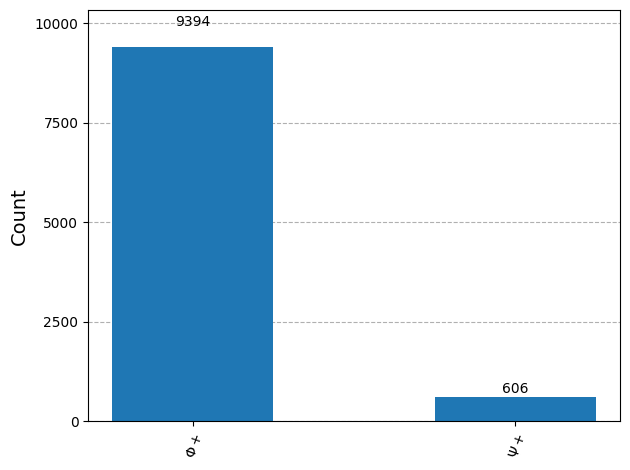

In [56]:
total_run = 0
purified_bp = 0
counts = {}
counts[f'$\Phi+$'] = 0
counts[f'$\Psi+$'] = 0

while total_run < 30000 and purified_bp < 10000:
    succ, res = is_purification_successful()
    total_run +=1

    if not succ:
        continue

    purified_bp += 1
    k = res
    if k == '00' or k == '11':
        counts[f'$\Phi+$'] = counts[f'$\Phi+$'] + 1
    else:
        counts[f'$\Psi+$'] = counts[f'$\Psi+$'] + 1

if total_run >= 30000:
    print('===================================')
    print('You probably did something wrong.\n\n')
    print('===================================')
elif purified_bp == 10000:
    print('Your solution is probably correct.\n\n')
    print('expected success probability is 68%')

print(f'successful purification counts: {purified_bp}')
print(f'    with success probability {purified_bp / total_run} ({purified_bp}/{total_run})')
plot_histogram(counts)

# Congratulations! You have finally made it to the end!

By now you should have grasped the basic concepts of quantum networking to a certain degree! We hope you liked this notebook and if you have any comments or suggestions feel free to tell us in the room or in slack. Any feedback is welcome!

Also we hope that you'll be interested in the area of quantum network and consider contributing to the field. We really need more people!